# Spotify Tracks Dataset
__Aprendizaje Automático Avanzado (AAA)__

_Alan García Justel_

Para el desarrollo de esta práctica, se ha elegido el dataset [Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset), el cual contiene información de $114$ géneros de música distintos. Este dataset puede ser utilizado para desarrollar aplicaciones de recomentación, clasificación de canciones o ingluso de predicción de popularidad.

En este notebook se explorará cómo emplear las **features descriptivas** para realizar clasificaciones en base al género de las canciones. Estas features son de tipo tabular y han sido recopiladas mediante diferentes métodos, los cuales se detallarán más adelante. No se hará uso de las pistas de audio en sí, ya que para ello serían necesarias técnicas de procesamiento de series temporales que escapan al alcance de esta asignatura. Por lo tanto, el objetivo principal de este cuaderno es desarrollar un sistema de clasificación basado en características previamente anotadas de las canciones.

Además, con el fin de acotar el problema, se ha decidido restringir el análisis a un problema de clasificación binaria, enfocándose en canciones pertenecientes a géneros musicales que caracterizan al **metal**. Los géneros musicales considerados como metal en este estudio son los siguientes:  

- black-metal  
- death-metal  
- grindcore  
- heavy-metal  
- industrial  
- metalcore  
- metal  

## Setup

In [52]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import zscore, wilcoxon
from scipy.spatial.distance import pdist, squareform

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
import joblib
import os

# warnings.filterwarnings("ignore", category=UserWarning)

## Dataset Exploration

El dataset se proporciona en un archivo **.csv**, por lo que se ha optado por utilizar la librería `pandas` para cargar y manipular los datos, así como para realizar una exploración inicial de las variables disponibles. El dataset contiene **114,000 instancias** y **21 características**, que describen diversas propiedades de las canciones. A continuación, se detallan las características más relevantes:

- **Unamed0**: Identificador único asignado a cada instancia por los creadores del dataset.
- **track_id**: Identificador único del track, que permite acceder a la secuencia de audio de la canción.
- **artists**: Nombre o nombres de los artistas de la canción. Si hay varios artistas, estos se separan por `;`.
- **album_name**: Nombre del álbum al que pertenece la canción.
- **track_name**: Nombre de la canción.
- **popularity**: Popularidad de la canción, medida en una escala de 0 a 100, donde 100 es la más popular. Este valor se calcula mediante un algoritmo que considera el número total de reproducciones y su frecuencia reciente. Canciones con muchas reproducciones actuales tendrán una popularidad más alta que aquellas que fueron populares en el pasado.
- **duration_ms**: Duración de la canción en milisegundos.
- **explicit**: Indica si la canción contiene letras explícitas (`true` = sí, `false` = no o desconocido).
- **danceability**: Mide qué tan adecuada es una canción para bailar, basándose en elementos como el tempo, la estabilidad del ritmo y la fuerza del beat. El valor varía de 0.0 (menos bailable) a 1.0 (más bailable).
- **energy**: Mide la intensidad y actividad de la canción en una escala de 0.0 a 1.0. Canciones con alta energía suelen ser rápidas, fuertes y ruidosas (por ejemplo, el death metal), mientras que las de baja energía son más suaves (por ejemplo, un preludio de Bach).
- **key**: La tonalidad de la canción, representada como un número entero que sigue la notación estándar de clases de tono. Por ejemplo, 0 = Do (C), 1 = Do♯/Re♭ (C♯/D♭), 2 = Re (D), etc. Si no se detecta tonalidad, el valor es -1.
- **loudness**: El volumen general de la canción en decibelios (dB).
- **mode**: Indica la modalidad de la canción: mayor (1) o menor (0).
- **speechiness**: Detecta la presencia de palabras habladas en la canción. Valores cercanos a 1.0 indican que la canción es principalmente hablada (por ejemplo, un audiolibro), mientras que valores entre 0.33 y 0.66 sugieren una mezcla de música y habla (por ejemplo, rap). Valores por debajo de 0.33 indican que la canción es principalmente música.
- **acousticness**: Mide la confianza de que la canción sea acústica, en una escala de 0.0 a 1.0. Un valor de 1.0 indica alta confianza en que la canción es acústica.
- **instrumentalness**: Predice si la canción contiene vocales. Valores cercanos a 1.0 indican que es probable que la canción no tenga contenido vocal.
- **liveness**: Detecta la presencia de una audiencia en la grabación. Valores altos (por encima de 0.8) sugieren que la canción fue grabada en vivo.
- **valence**: Mide la positividad musical de la canción en una escala de 0.0 a 1.0. Canciones con alta valencia suenan más positivas (felices, alegres), mientras que las de baja valencia suenan más negativas (tristes, deprimentes).
- **tempo**: El tempo estimado de la canción en pulsaciones por minuto (BPM).
- **time_signature**: Indica cuántos pulsos hay en cada compás. Los valores van de 3 a 7, representando firmas de tiempo como 3/4, 4/4, etc.
- **track_genre**: El género musical al que pertenece la canción.

In [3]:
df = pd.read_csv('../../data/AAA/spotify_tracks.csv')
print(f"data_frame shape: {df.shape}")
df.head()

data_frame shape: (114000, 21)


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [4]:
df.describe()

Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  114000.000000  114000.000000     114000.000000  114000.000000   
mean        0.084652       0.314910          0.156050       0.213553   
std         0.105732       0.332523          0.309555       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.598000          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  114000.000000  114000.000000   114000.000000  
mean        0.474068     122.147837        3.904035  
std         0.259261      29.978197        0.432621  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218750        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

Al encontrarnos con estos datos surgen varias cuestiones:
- **Distribución de géneros musicales**: ¿Cómo se distribuye el número de instancias de cada género musical? ¿Está el dataset balanceado o hay desequilibrios entre géneros?
- **Valores faltantes**: ¿Hay missing values en el dataset? De ser así, ¿cómo los tratamos?
- **Entradas duplicadas**: ¿Hay filas duplicadas? De ser así, ¿qué hacemos con ellas?
- **Tipos de datos**: ¿Qué tipos de datos hay? ¿Variables continuas, discretas, binarias o categóricas?
- **Escalado de datos**: ¿Es necesario escalar los datos para que todas las variables contribuyan equitativamente en los modelos?
- **Correlación entre géneros**: ¿Cómo de correlacionados están los distintos géneros musicales?
- **Relación entre variables y géneros**: ¿Qué relación existe entre las variables descriptivas, como la _energía_, y los géneros musicales de las canciones?

Por esta razón, se va a realizar un **estudio exploratorio de los datos** con los siguientes objetivos:
1. Detectar y tratar valores faltantes y entradas duplicadas.
2. Preprocesar los datos, incluyendo la normalización o estandarización de variables.
3. Estudiar las correlaciones entre las features y las relaciones entre los géneros musicales.
4. Visualizar los datos y sus distribuciones.
5. Identificar outliers.

#### 1 - Valores faltantes

Existe una instancia del dataset que tiene todos los datos exceptuando aquellos relacionados con los nombres del artista, el álbum y el nombre de la canción. Sin embargo, sí que contamos con el _track_id_ de la canción, por lo que podemos hacer una consulta rápida mediante la _API_ de spotify para recuperar los datos faltantes de la canción.

In [6]:
exist_missing_values = False
for i, is_null in enumerate(df.isnull().sum()):
    if is_null:
        exist_missing_values = True
        print(f"La variable '{df.columns[i]}' presenta {is_null} missing values")

df[df.isnull().any(axis=1)]

La variable 'artists' presenta 1 missing values
La variable 'album_name' presenta 1 missing values
La variable 'track_name' presenta 1 missing values


Unnamed: 0                track_id artists album_name track_name  \
65900       65900  1kR4gIb7nGxHPI3D2ifs59     NaN        NaN        NaN   

       popularity  duration_ms  explicit  danceability  energy  ...  loudness  \
65900           0            0     False         0.501   0.583  ...     -9.46   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
65900     0       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature  track_genre  
65900  138.391               4        k-pop  

[1 rows x 21 columns]

In [7]:
def buscar_datos_cancion(track_id:str):
    """
    Se ha de contar con las variables de entorno SPOTIFY_CLIENT_ID y 
    SPOTIFY_CLIENT_SECRET de Spotify Developers para poder acceder 
    a la API de Spotify.
    """
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials

    # Configura tus credenciales
    CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
    CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")
    if not CLIENT_ID or not CLIENT_SECRET:
        raise ValueError("Asegúrate de que las variables de entorno SPOTIFY_CLIENT_ID y SPOTIFY_CLIENT_SECRET están configuradas.")

    # Autenticación
    auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
    sp = spotipy.Spotify(auth_manager=auth_manager)

    # Imprimir el nombre de la canción y el artista
    track_info = sp.track(track_id)
    print(f"Nombre de la canción: {track_info['name']}")
    print(f"Artista: {'; '.join(artist['name'] for artist in track_info['artists'])}")

buscar_datos_cancion(track_id="1kR4gIb7nGxHPI3D2ifs59")

Nombre de la canción: 
Artista: 


In [7]:
duplicates = df.duplicated().sum()
print(f"Existen {duplicates} instancias duplicadas.")

Existen 0 instancias duplicadas.


Sin embargo, al realizar una consulta a la **API de Spotify**, se observa que los datos de la canción en cuestión siguen estando omitidos. Dado que este caso es aislado y los datos faltantes no afectan a las **features** utilizadas en el entrenamiento de los modelos (sólo es información útil para identificar la canción), se ha decidido ignorar este caso.

Por otro lado, no se han encontrado entradas duplicadas.

In [ ]:
counts = df['track_genre'].value_counts()
print(f"El dataset presenta {len(counts)} géneros musicales distintos.")

distinc_nums = []
for c in counts:
    if c not in distinc_nums:
        distinc_nums.append(c)

if len(distinc_nums) == 1:
    print(f"Cada género musical tiene {distinc_nums[0]} instancias.")
else:
    print(f"Hay géneros con estos números de instancias: {distinc_nums}.")

El dataset presenta 114 géneros musicales distintos.
El dataset está balanceado y cada género musical tiene 1000 instancias.


#### 2 - Preprocesar los datos

Como se ha visto, hay varias variables que únicamente aportan información para la identificación de las pistas de audio. Por ello, las variables `"Unnamed: 0"`, `"track_id"`, `"artists"`, `"album_name"` y `"track_name"` no se van a tener en cuenta.

Por otro lado, el dataset presenta $3$ tipos de variables que se van a tratar de forma distinta:
- Nominales: `"time_signature"` y `"key"`. Toman valores numéricos, pero indican categorías. Se va a realizar un 'One-Hot-Encoding' de estas variables.
- Binarias: `"mode"` y `"explicit"`. No se van a tratar
- Numéricas: todas las demás. Se van a escalar.

Además, los géneros musicales se presentan es strings, por lo que es interesante codificarlos (sobre todo para que los nombres no ocupen mucho a la hora de graficar).

In [56]:
# One-Hot-Encoding de la variable 'time_signature' 
df = pd.get_dummies(df, columns=['time_signature'], prefix='ts')
df = pd.get_dummies(df, columns=['key'], prefix='k')

# Codificar la variable 'track_genre' para análisis
LE = LabelEncoder()
df["track_genre_encoded"] = LE.fit_transform(df["track_genre"])
non_feature_columns = ["Unnamed: 0", "track_id", "artists", "album_name", "track_name", "track_genre", "track_genre_encoded"]

KeyError: "None of [Index(['time_signature'], dtype='object')] are in the [columns]"

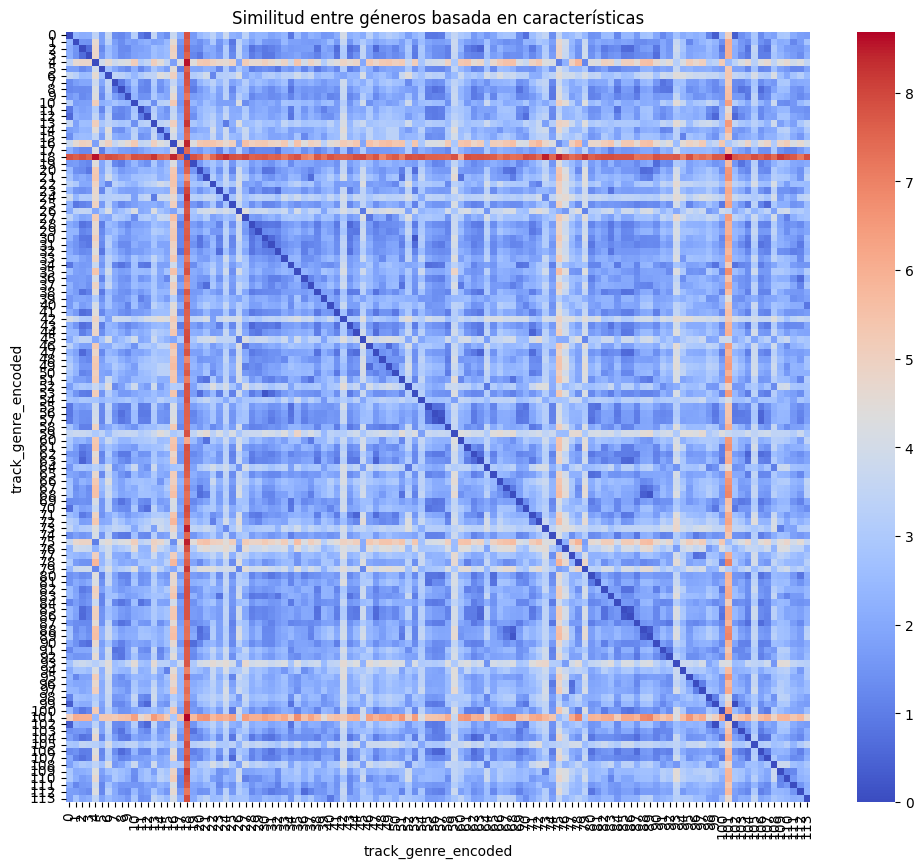

In [10]:
# Estandarizar los datos
scaler = StandardScaler()
non_scaling_features = [ 'ts_0', 'ts_1', 'ts_3', 'ts_3', 'ts_5', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k_6', 'k_7', 'k_8', 'k_9', 'k_10', 'k_11', 'mode']
scaled_features = scaler.fit_transform(df.drop(columns=non_feature_columns + non_scaling_features))
df_scaled = pd.DataFrame(scaled_features, columns=df.drop(columns=non_feature_columns + non_scaling_features).columns)

for feature in non_scaling_features:
    df_scaled[feature] = df[feature].values
for feature in non_feature_columns:
    df_scaled[feature] = df[feature].values
df = df_scaled

#### 3 - Estudio de correlaciones

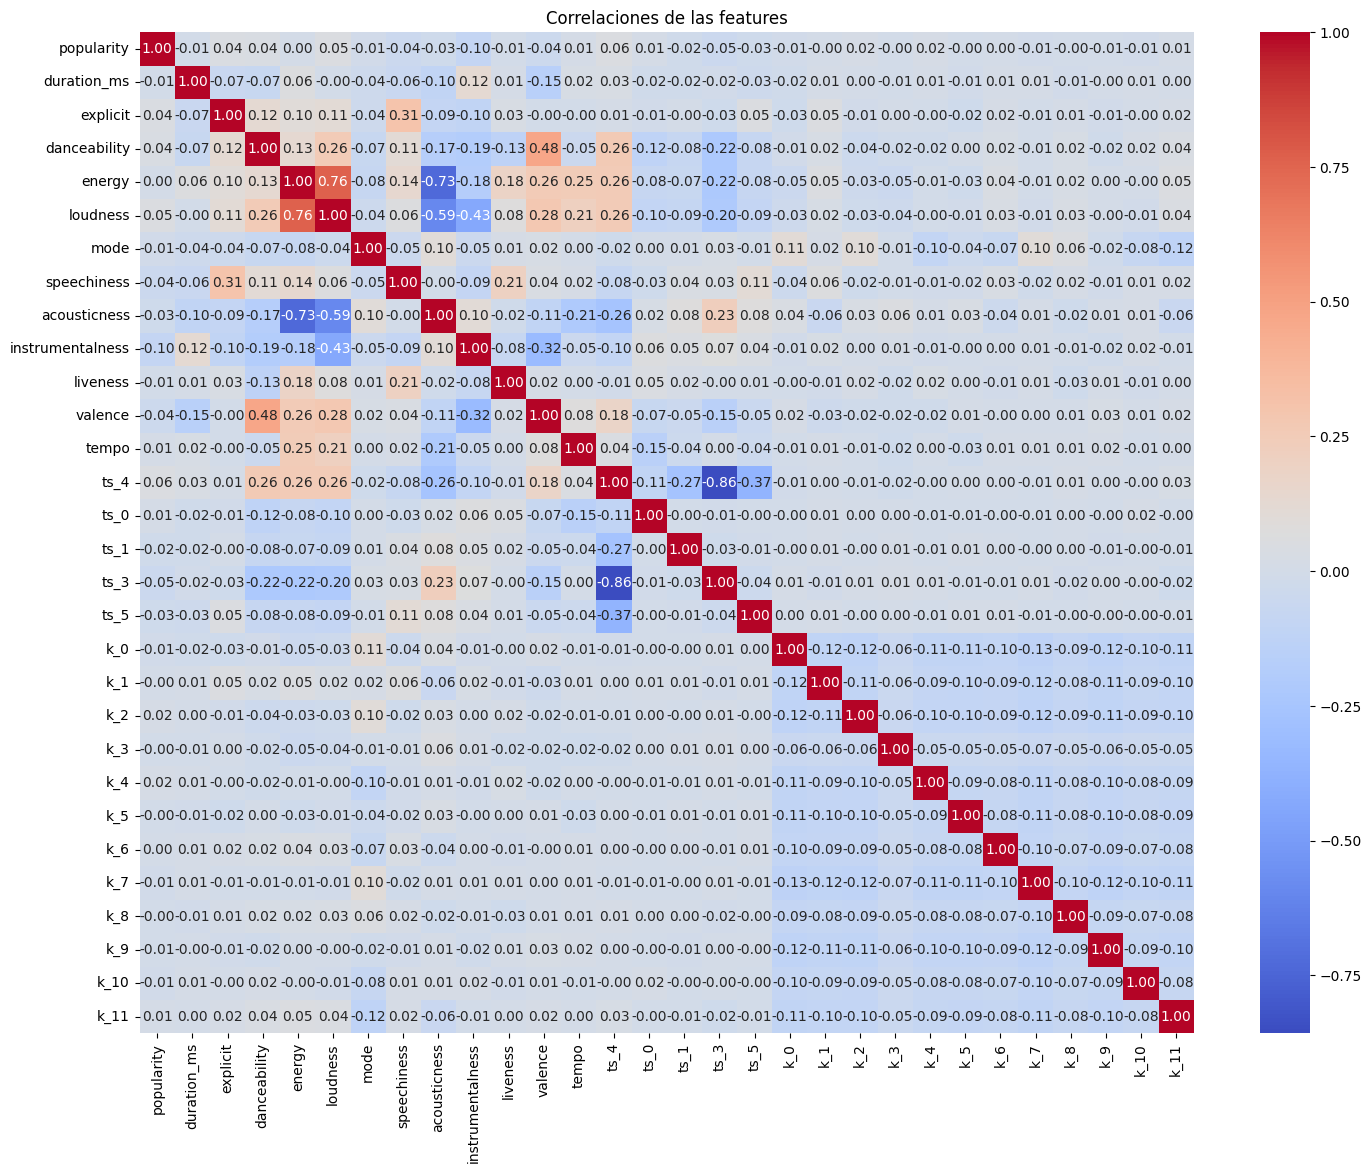

In [59]:
correlation_matrix = df.drop(columns=non_feature_columns).corr()

plt.figure(figsize=(17, 13))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlaciones de las features")
plt.show()

A partir de esta matriz de correlaciones entre las características de las canciones, se pueden extraer varias conclusiones:

En primer lugar, destaca la correlación positiva entre la energía de una canción y su nivel de volumen ('loudness'), lo cual resulta lógico, ya que las canciones con mayor energía suelen tener una producción más intensa y un sonido más potente.

Por otro lado, también es interesante la correlación negativa entre la energía y la 'acousticness'. Esto podría deberse a que las canciones más acústicas tienden a ser más suaves y orgánicas, mientras que aquellas con mayor energía suelen incorporar instrumentación eléctrica y una producción más intensa.

Otro aspecto relevante es la correlación positiva entre la 'danceability' y la valencia, lo que sugiere que las canciones con un índice de positividad más alto tienden a ser más bailables.

En la matriz también se observan correlaciones entre las 'time_signatures', todas ellas negativas, lo cual tiene sentido, ya que una canción no puede tener simultáneamente dos compases distintos. Destacan los compases 3/4 y 4/4, que parecen ser los más habituales. Además, el compás 3/4 muestra una mayor correlación con canciones de carácter acústico, mientras que el 4/4 está más asociado a temas con mayor bailabilidad, energía y positividad.

In [ ]:
# Agrupar por género
genre_profiles = df.drop(columns=non_feature_columns)
genre_profiles['track_genre_encoded'] = df['track_genre_encoded']
genre_profiles = genre_profiles.groupby('track_genre_encoded').mean()

# Calcular una matriz de distancia entre géneros
# metric: ['euclidean', 'cosine', 'correlation']
distance_matrix = pdist(genre_profiles, metric='euclidean')
distance_df = pd.DataFrame(
    squareform(distance_matrix),
    index=genre_profiles.index,
    columns=genre_profiles.index
)

# Visualizar la matriz de distancias
plt.figure(figsize=(12, 10))
sns.heatmap(distance_df, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Similitud entre géneros basada en características')
plt.show()

In [11]:
# Crear una lista de pares de géneros con sus distancias
processed_pairs = set()
pairs = []
for genre1 in distance_df.columns:
    for genre2 in distance_df.columns:
        if genre1 != genre2:
            # Esto se puede hacer porque estamos considerando una funcion de distancia es simétrica            
            if (genre1, genre2) not in processed_pairs and (genre2, genre1) not in processed_pairs:
                pairs.append((int(genre1), int(genre2), distance_df.loc[genre1, genre2]))
                processed_pairs.add((genre1, genre2))
                

# Convertir la lista en un DataFrame
pairs_df = pd.DataFrame(pairs, columns=['genre_encoded_1', 'genre_encoded_2', 'distance'])
pairs_df['genre_1'] = LE.inverse_transform( pairs_df['genre_encoded_1'] )
pairs_df['genre_2'] = LE.inverse_transform( pairs_df['genre_encoded_2'] )
sorted_pairs = pairs_df.sort_values(by='distance')

print("Lista de pares de géneros musicales más similares en base a la disimilaridad calculada:")
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', None)  # Evita el corte de texto largo
print(sorted_pairs)

Lista de pares de géneros musicales más similares en base a la disimilaridad calculada:
      genre_encoded_1  genre_encoded_2      distance            genre_1  \
6338               99              102  6.938894e-18  singer-songwriter   
6035               85               86  1.785720e-01               punk   
2977               30               53  1.848602e-01                edm   
5426               68               89  1.956044e-01             latino   
4788               56               57  2.003219e-01              indie   
6116               88               89  2.823100e-01             reggae   
101                 0              102  3.511608e-01           acoustic   
98                  0               99  3.511608e-01           acoustic   
5425               68               88  3.991746e-01             latino   
4245               47               63  4.560971e-01          hard-rock   
285                 2               63  4.804774e-01           alt-rock   
4893        

Estamos calculando la matriz de similitudes en base a las distancias de las medias normalizadas de cada una de las variables agrupadas por género. Es por ello que surge la siguiente cuestión: ¿Son la media y la desviación típica estadísticos representativos de las variables?

Para que fuese así, los datos deberían de estar simétricamente distribuidos, no deberían de estar sesgados (poca presencia de outliers) y no deberían de ser asimétricos. Por ello, se ha decidido representar las distribuciones de cada una de las variables en un violin plot en el cual se puede distinguir visualmente. Así, se puede observar cómo muy pocas variables se aproximan a una distribución normal a excepción  de las variables de duración y "bailabilidad", las cuales sí se asemejan en cierta manera a una distribución normal (al menos de forma visual). Además, 


La variable `mode` es booleana, no es representativo el violin plot. 
La variable `time_signature` toma valores discretos 0-7, no es representativo el violin plot.
La variable `liveness` o de presencia de multitudes en el audio parece presentar outliers.
La variable `speechiness` también parece presentar outliers a la derecha.


En este punto nos encontramos con dos vías de estudio principales. En primer lugar, hay que comprobar si efectivamente las variables de duración y "bailabilidad" siguen distribuciones normales o es solo.

11


/workspaces/KISA/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 114000.
  res = hypotest_fun_out(*samples, **kwds)
/workspaces/KISA/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 114000.
  res = hypotest_fun_out(*samples, **kwds)
/workspaces/KISA/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 114000.
  res = hypotest_fun_out(*samples, **kwds)
/workspaces/KISA/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 114000.
  res = hypotest_fun_out(*samples, **kwds)
/workspaces/KISA/.venv/lib/python3.12/site-p

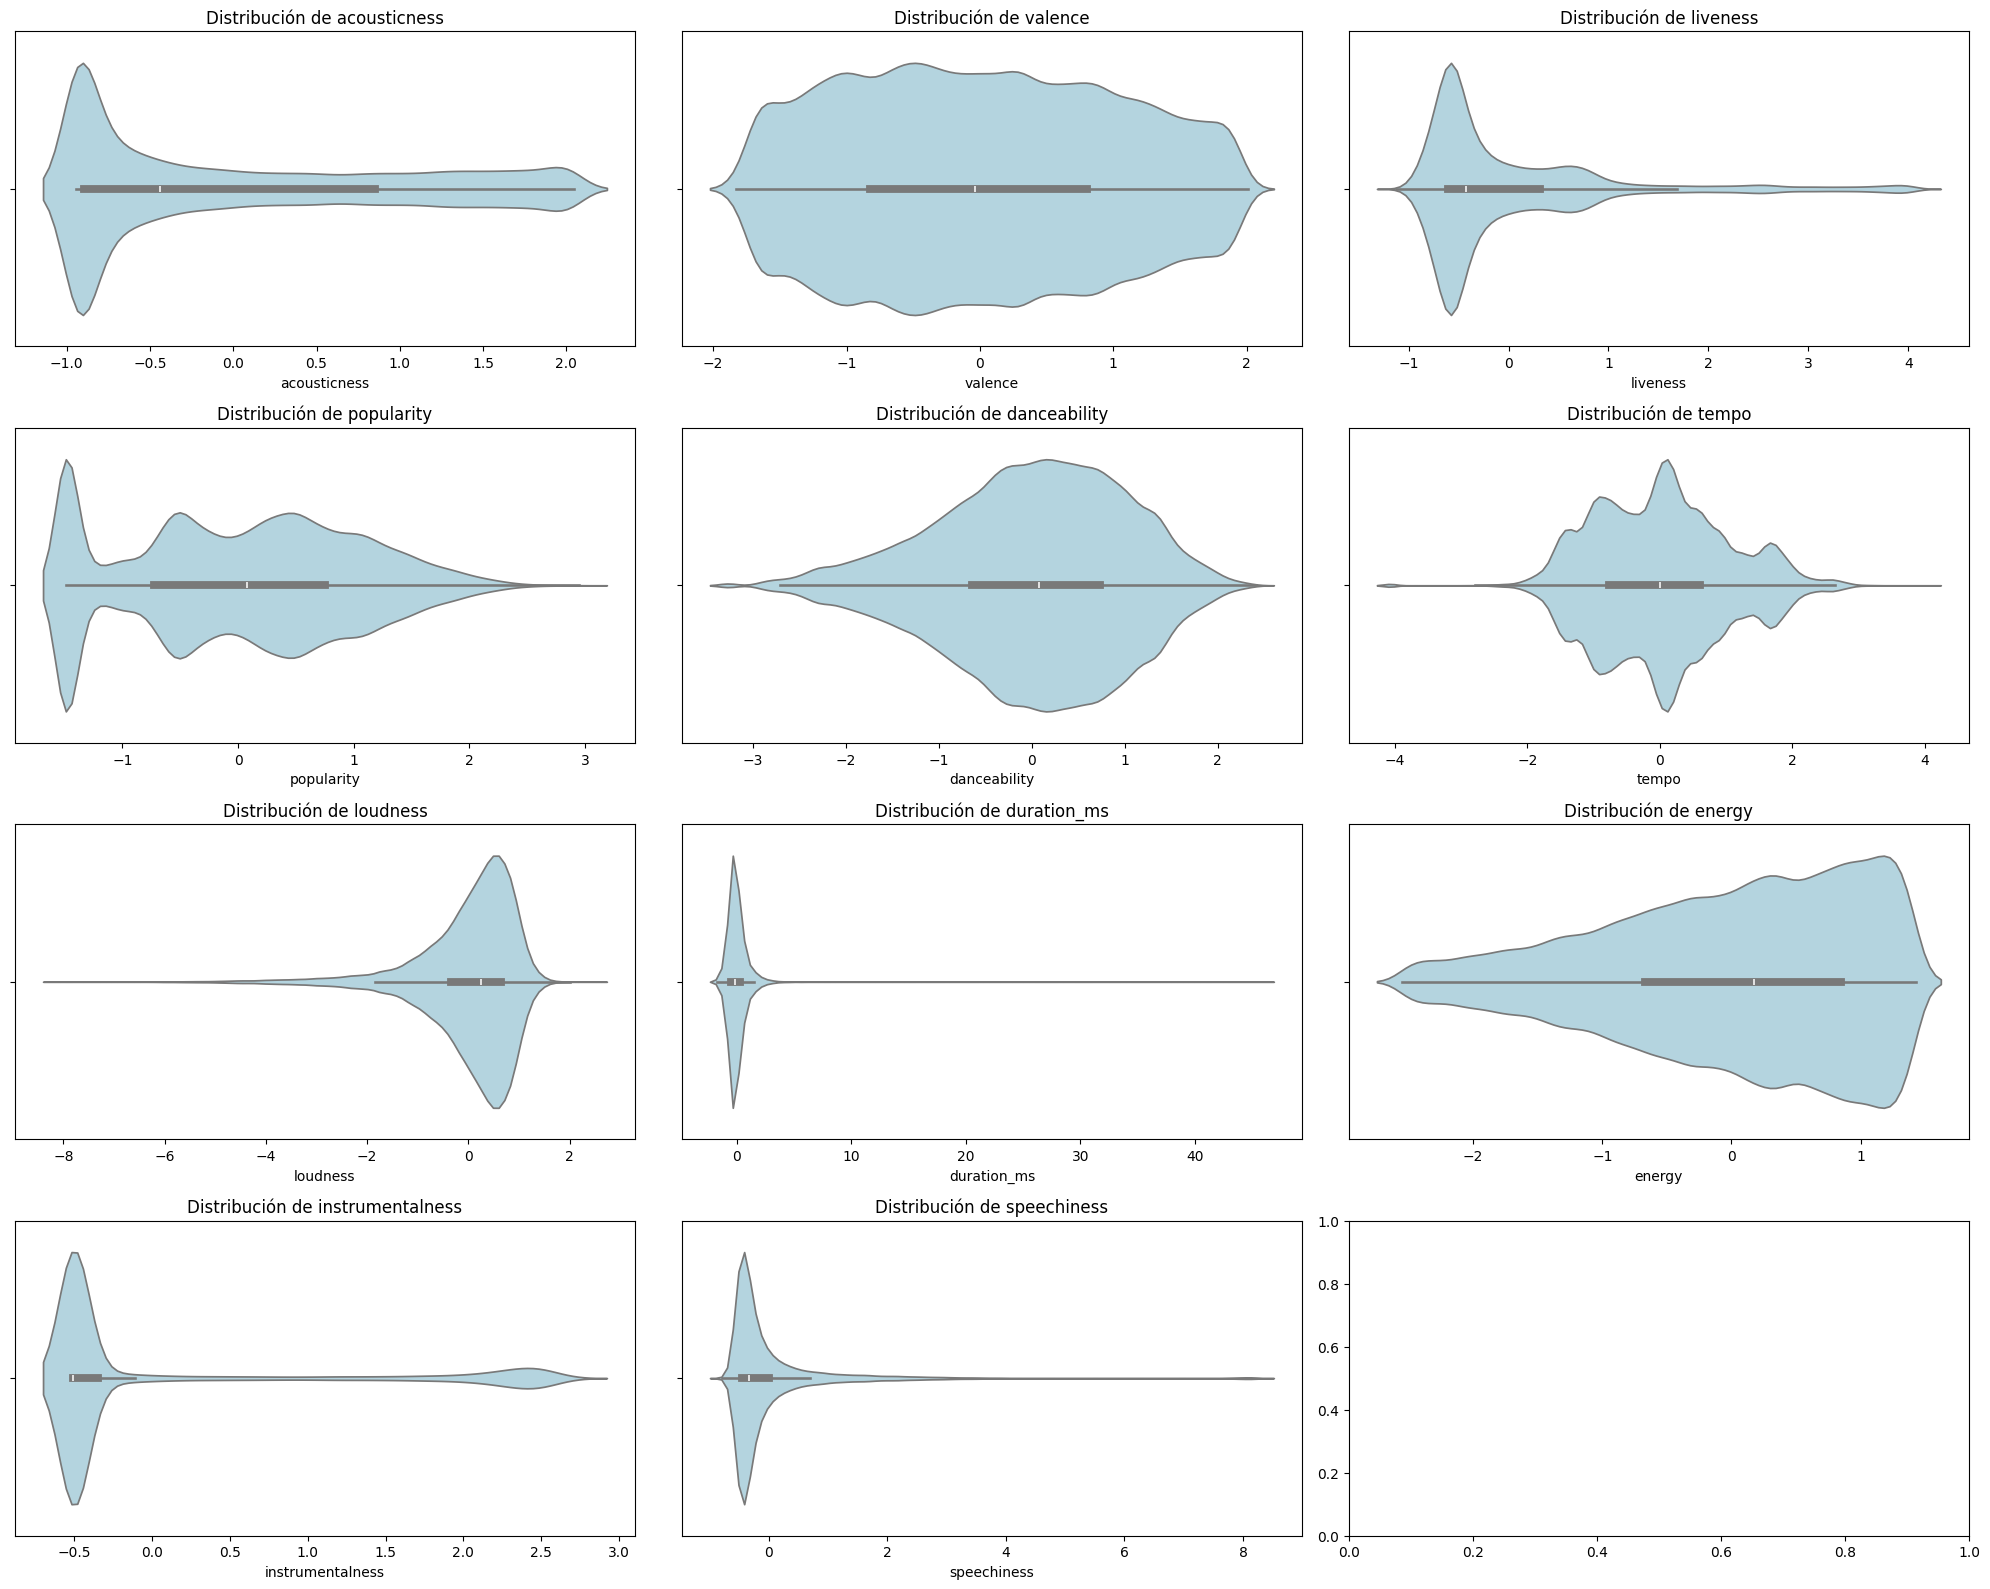

In [17]:
from scipy.stats import skew, kurtosis, shapiro

selected_columns = ['acousticness', 'valence', 'liveness', 'popularity', 'danceability', 
                    'tempo', 'loudness', 'duration_ms', 'energy', 'instrumentalness', 'speechiness' ]
# Non selected columns: track_genre_encoded, mode, explicit, time_signature
print(len(selected_columns))
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()


# Violin plot para cada variable numérica
stat_data = {}
for i, column in enumerate(selected_columns):
    sns.violinplot(x=df[column], color='lightblue', ax=axes[i])
    axes[i].set_title(f'Distribución de {column}')
    axes[i].set_xlabel(column)

    # Cálculo de asimetría y curtosis
    mean = df[column].mean()
    std_dev = df[column].std()
    column_skewness = skew(df[column].dropna())
    column_kurtosis = kurtosis(df[column].dropna())
    stat, p_value = shapiro(df[column].dropna())
    
    stat_data[column] = {
        "mean": mean,
        "std_dev": std_dev,
        "skewness": column_skewness,
        "kurtosis": column_kurtosis,
        "shapiro":{"stat": stat, "p_value": p_value}
    }

plt.tight_layout()
plt.show()

In [18]:
for sd in stat_data.keys():
    if stat_data[sd]['shapiro']['p_value'] > 1e-10:
        print(stat_data[sd])

In [19]:
stat_data['duration_ms']

{'mean': np.float64(2.3934071099287587e-17),
 'std_dev': np.float64(1.0000043859937675),
 'skewness': np.float64(11.195034174569578),
 'kurtosis': np.float64(354.936795114302),
 'shapiro': {'stat': np.float64(0.6586784875945821),
  'p_value': np.float64(7.217900620336316e-152)}}

Ninguna variable parece presentar un p-valor superior a $1 \times 10^{-10}$ en el test de _Saphiro-Wilk_, por lo que es estadisticamente significativo el decir que ninguna de ellas se aproxima a una distribución normal. Por otro lado, es interesante realizar este mismo estudio visual agrupando los datos por su género musical correspondiente ya que puede darse el caso de que las anomalías y distintas distribuciones se deban al agrupamiento y el estudio global de todos los datos sin tener en cuenta los géneros musicales de cada instancia.
Sin embargo, al haber 114 géneros musicales distintos, es complicada la visualización en este tipo de diagrama. 


Por ello, se proponen dos métodos para realizar la visualización:
1. Agrupar los géneros musicales empleando un algoritmo de clustering aglomerativo generando clusters en base a la matriz de similaridad expuesta anteriormente.
2. Seleccionar de forma aleatoria un género musical y visualizar su distribución

Agrupaciones de géneros musicales calculadas:
cluster
0     [dancehall, emo, funk, hardcore, hip-hop, j-da...
1     [breakbeat, drum-and-bass, happy, hardstyle, t...
2                         [chill, french, sad, turkish]
3                                      [opera, romance]
4     [acoustic, british, cantopop, gospel, mandopop...
5                          [country, malay, rock, soul]
6        [bluegrass, children, rock-n-roll, rockabilly]
7     [death-metal, dubstep, grunge, heavy-metal, in...
8     [blues, brazil, folk, indian, indie, indie-pop...
9     [anime, club, deep-house, dub, edm, electro, e...
10    [alt-rock, alternative, disco, garage, goth, h...
11                                 [afrobeat, trip-hop]
12                                      [j-idol, party]
13                                   [ambient, new-age]
14                                            [iranian]
15                                             [comedy]
16      [dance, kids, latin, latino, reggae, regga

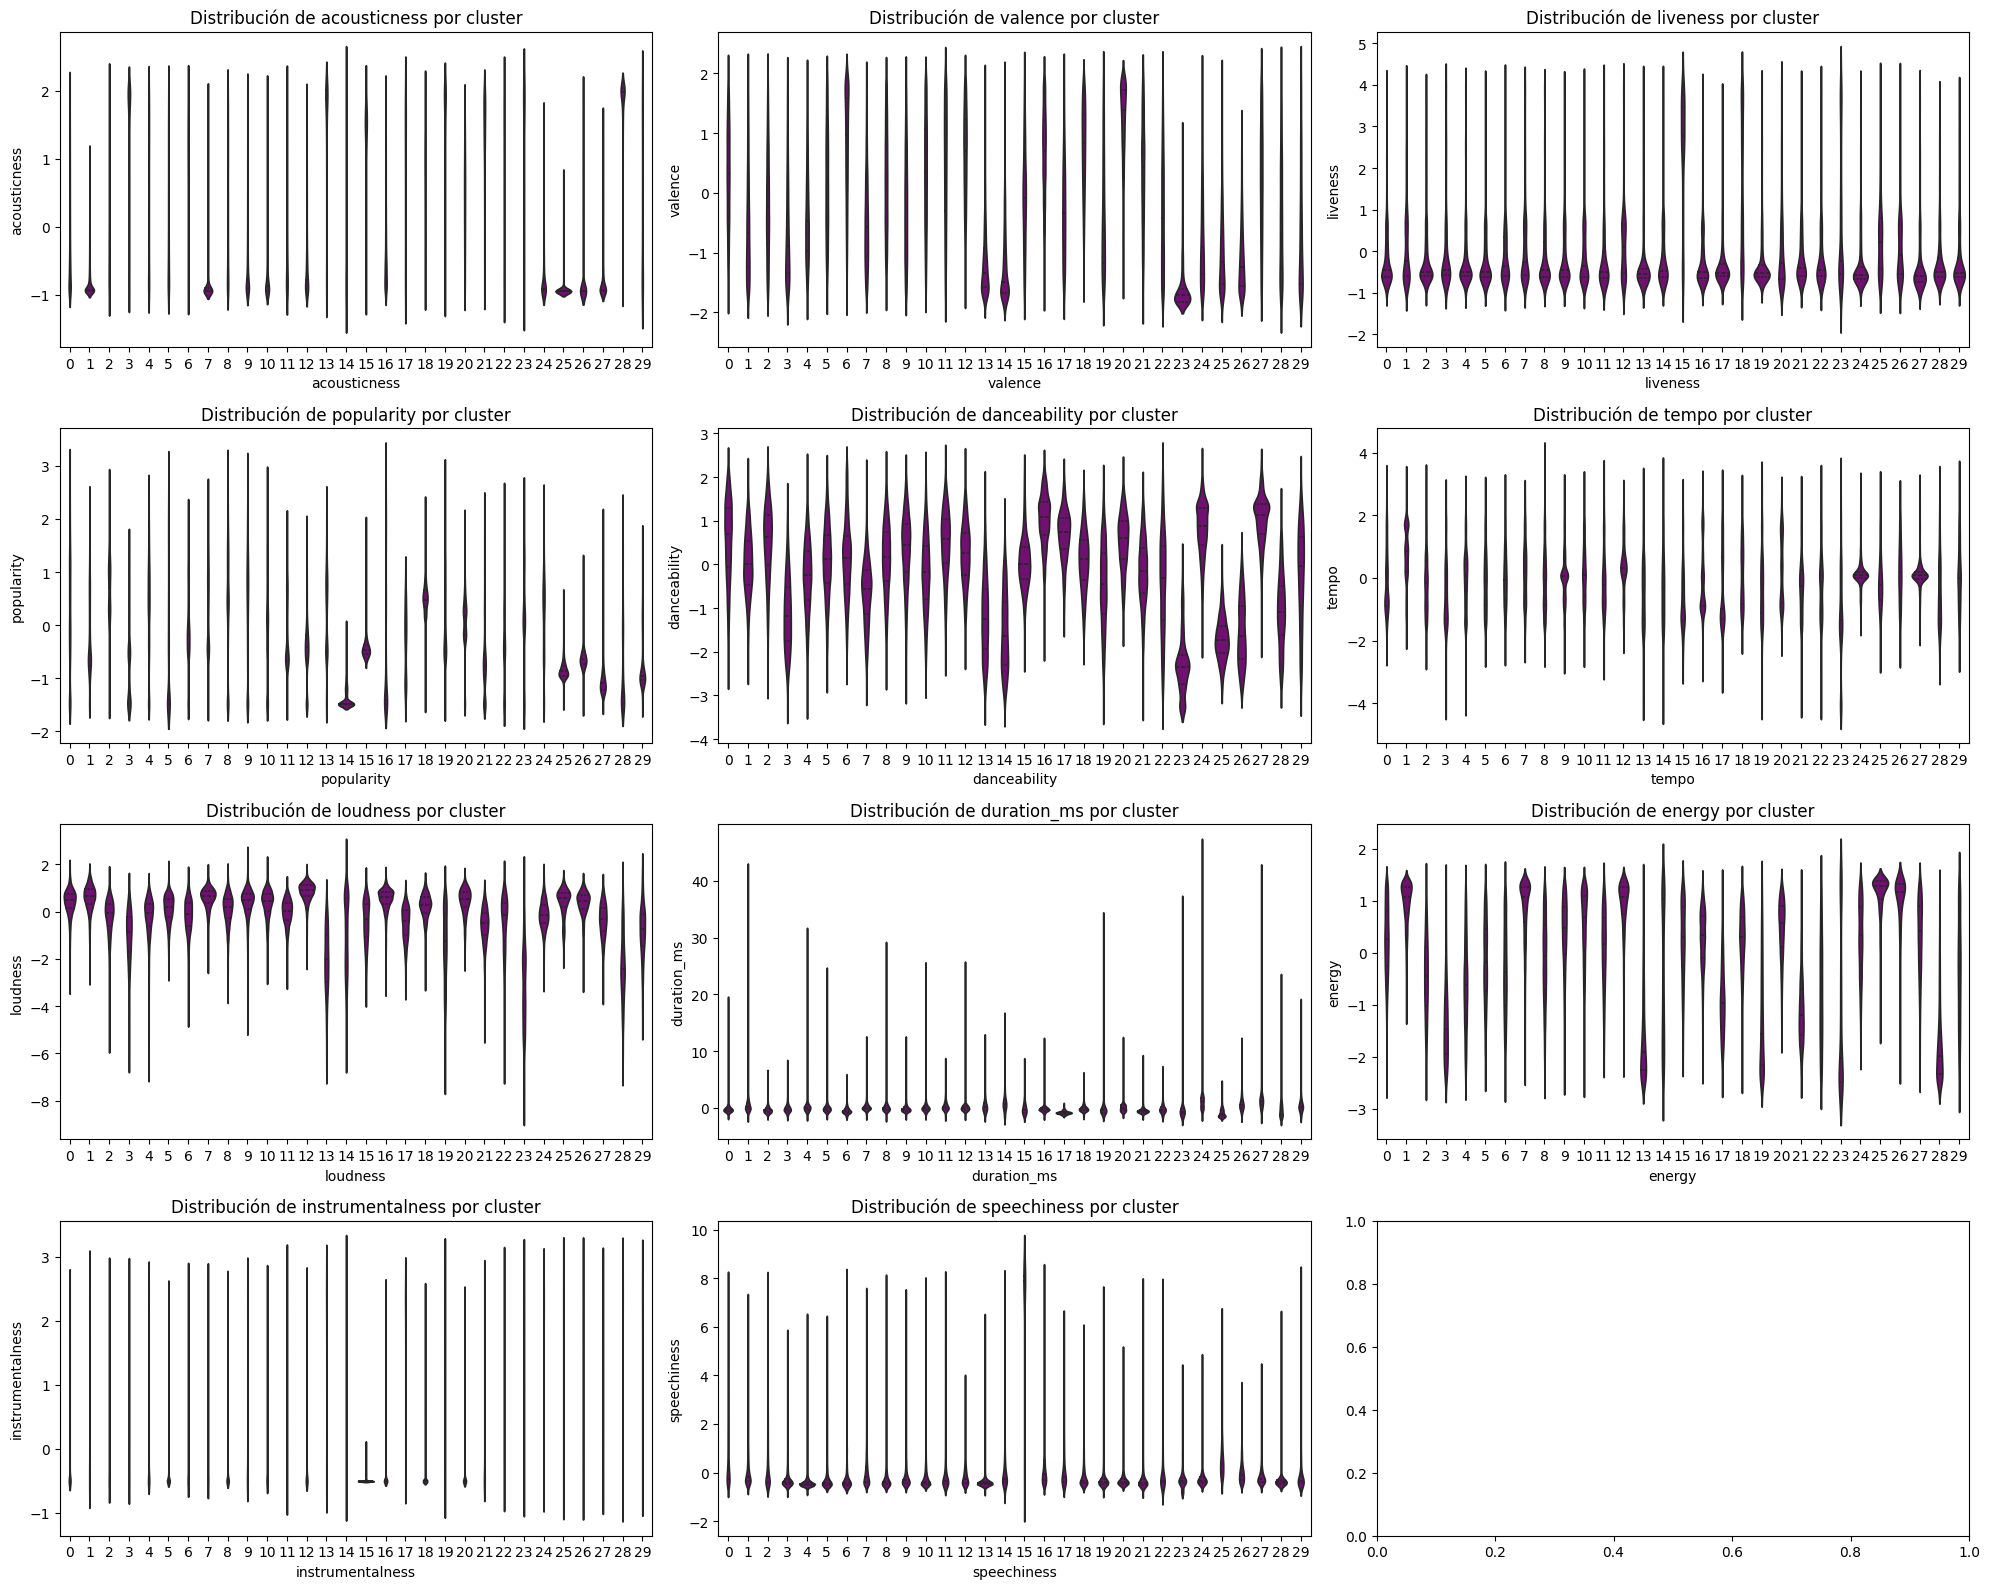

In [20]:
n_clusters = 30 # partiendo de 114
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
cluster_labels = clustering.fit_predict(squareform(distance_matrix))

# Crear un DataFrame para ver cómo se agrupan los géneros
clustered_genres = pd.DataFrame({
    'track_genre_encoded': distance_df.columns,
    'cluster': cluster_labels
})

# Asignar los nuevos clusters a los géneros musicales
clustered_genres['track_genre'] = LE.inverse_transform(clustered_genres['track_genre_encoded'].astype(int))
print("Agrupaciones de géneros musicales calculadas:")
CE = clustered_genres.groupby('cluster')['track_genre'].apply(list) # Cluster Encoder
print(CE)


# Hacer un violin plot por cada variable y cada cluster agrupando los datos
df['cluster'] = df['track_genre_encoded'].map(clustered_genres.set_index('track_genre_encoded')['cluster'])
non_feature_columns.append("cluster")

selected_columns = ['acousticness', 'valence', 'liveness', 'popularity', 'danceability', 
                    'tempo', 'loudness', 'duration_ms', 'energy', 'instrumentalness', 'speechiness']
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    sns.violinplot(x='cluster', y=column, data=df, color='purple', inner="quart", ax=axes[i])
    axes[i].set_title(f'Distribución de {column} por cluster')
    axes[i].set_xlabel(column)
plt.tight_layout()
plt.show()


11


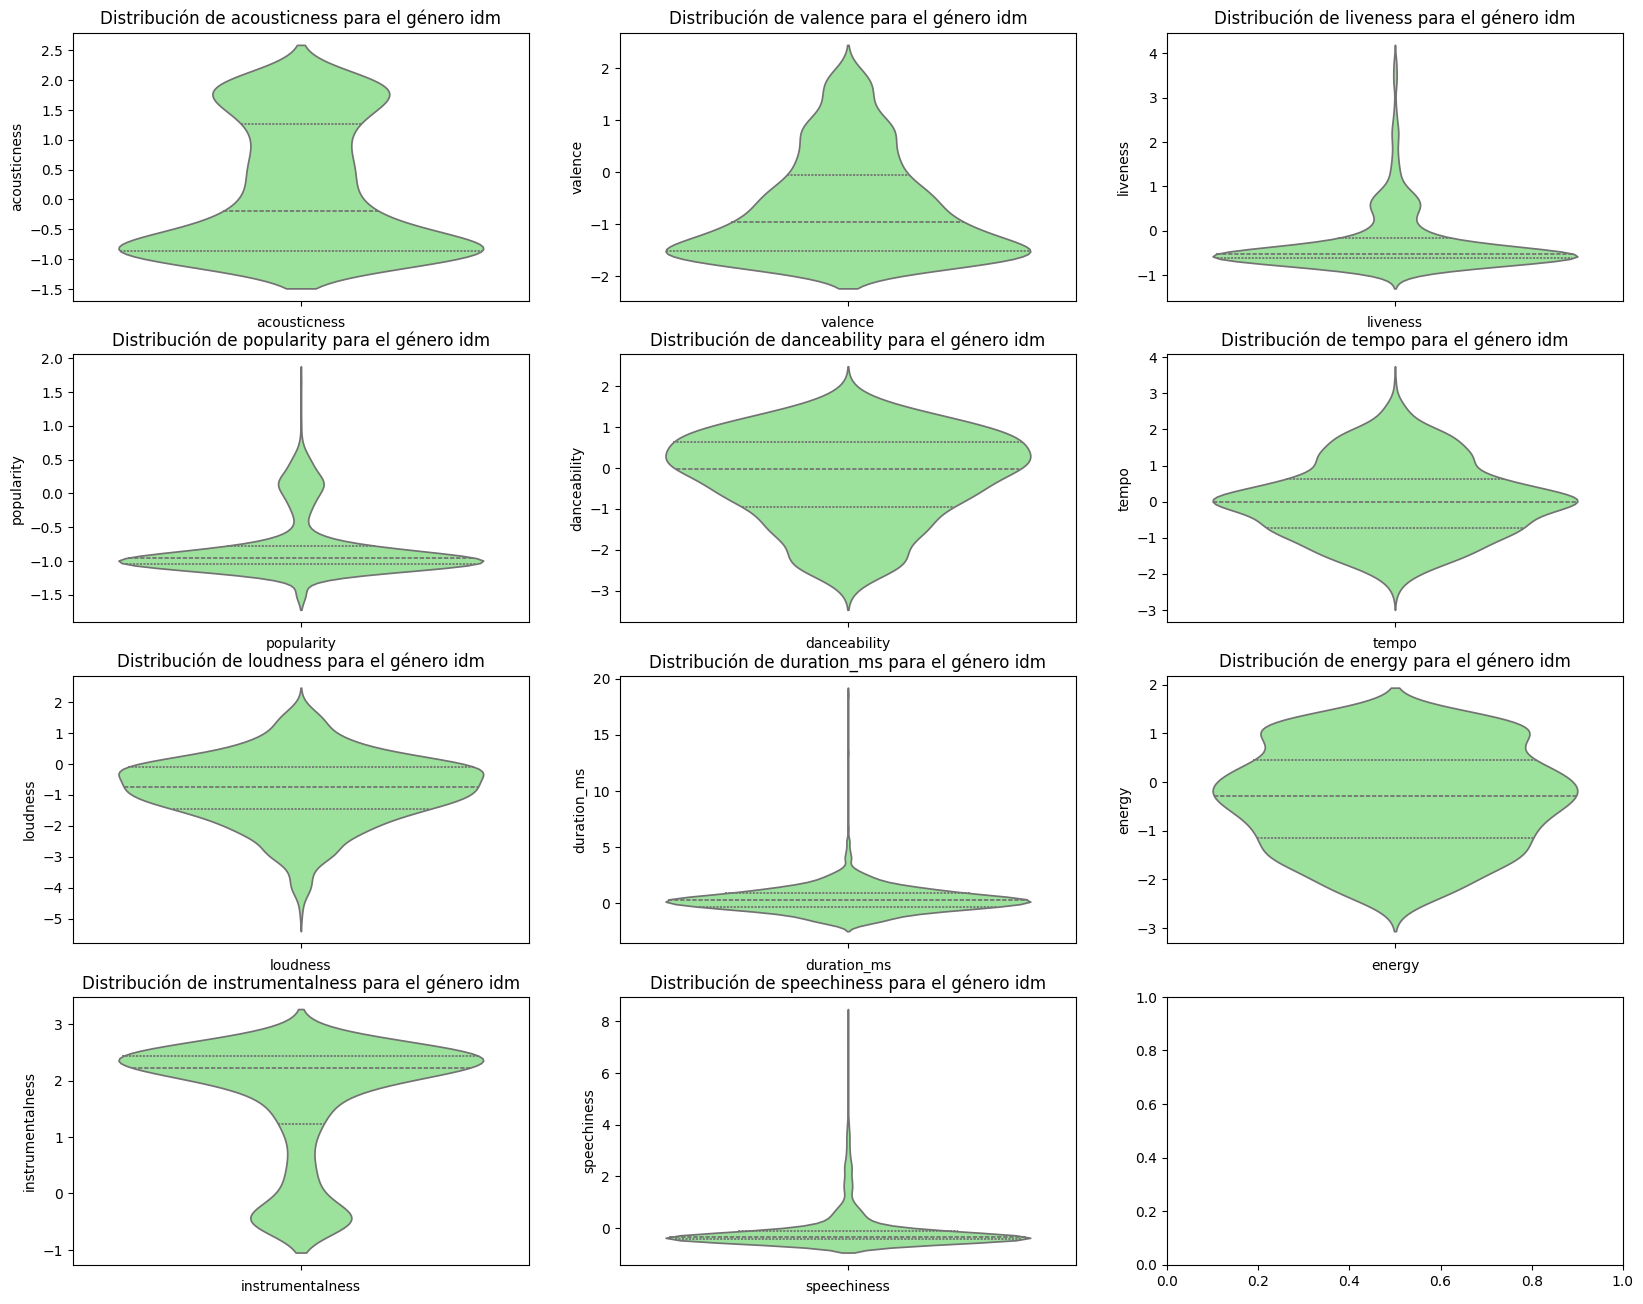

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [23]:
selected_columns = ['acousticness', 'valence', 'liveness', 'popularity', 'danceability', 
                    'tempo', 'loudness', 'duration_ms', 'energy', 'instrumentalness', 'speechiness' ]
# Non selected columns: track_genre_encoded, mode, explicit, time_signature
print(len(selected_columns))
selected_genre = np.random.randint(low=0, high=len(LE.classes_))
filtered_df = df[df['track_genre_encoded'] == selected_genre]

# Crear un gráfico de violín para cada columna seleccionada
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    plt.figure(figsize=(10, 6))  # Tamaño de cada gráfico
    sns.violinplot(y=column, data=filtered_df, inner="quart", color="lightgreen", ax=axes[i])
    axes[i].set_title(f'Distribución de {column} para el género {LE.classes_[selected_genre]}')
    axes[i].set_xlabel(column)
    
plt.tight_layout()
plt.show()

La conclusión general es que ni agrupando por clusters o por clases se consiguen datos distribuidos de forma normal. Esto puede deberse a que las canciones, aunque pertenezcan a un género en específico, pueden contener rasgos de otros géneros musicales. No todo es blanco o negro. Es por ello que también es interesante detectar estos outliers para ver cómo se comportan. Además, a la hora de hacer un clasificador quizás no sea lo óptimo uno que clasifique canciones proporcionando un único género musical como salida, si no un abanico de distintos géneros musicales con mayor o menor probabilidades.

Considerando este análisis, los clústeres de agrupación obtenido y los objetivos didácticos de esta práctica, se propone estudiar un problema de clasificación binaria en el que se pretende detectar si una instancia pertenece al siguiente grupo de canciones o no:


In [24]:
# Create the binary target variable
metal_genres = ['black-metal', 'death-metal', 'grindcore', 'heavy-metal', 'industrial', 'metalcore', 'metal']
df['is_metal'] = df['track_genre'].apply(lambda x: 1 if x in metal_genres else 0)
non_feature_columns.append("is_metal")
df.head()

popularity  duration_ms  explicit  danceability    energy  loudness  \
0    1.782627     0.024575 -0.305767      0.629244 -0.717148  0.300828   
1    0.975633    -0.730859 -0.305767     -0.845908 -1.889980 -1.784744   
2    1.065299    -0.160332 -0.305767     -0.742186 -1.122669 -0.293288   
3    1.692961    -0.243214 -0.305767     -1.733304 -2.312994 -2.039252   
4    2.186125    -0.271919 -0.305767      0.295030 -0.788711 -0.282750   

       mode  speechiness  acousticness  instrumentalness  liveness   valence  \
0 -1.326281     0.551848     -0.850202         -0.504109  0.758743  0.929306   
1  0.753988    -0.078993      1.831732         -0.504094 -0.591211 -0.798690   
2  0.753988    -0.273826     -0.315499         -0.504112 -0.507167 -1.365688   
3  0.753988    -0.457309      1.774593         -0.503883 -0.428376 -1.276974   
4  0.753988    -0.303145      0.463399         -0.504112 -0.686285 -1.184403   

      tempo      ts_4   ts_0   ts_1   ts_3   ts_5    k_0    k_1    k_2    k_3  \
0 -1.141863  0.345500  False  False  False  False  False   True  False  False   
1 -1.489717  0.345500  False  False  False  False  False   True  False  False   
2 -1.528312  0.345500  False  False  False  False   True  False  False  False   
3  1.987859 -2.894359  False  False   True  False   True  False  False  False   
4 -0.073348  0.345500  False  False  False  False  False  False   True  False   

     k_4    k_5    k_6    k_7    k_8    k_9   k_10   k_11  Unnamed: 0  \
0  False  False  False  False  False  False  False  False           0   
1  False  False  False  False  False  False  False  False           1   
2  False  False  False  False  False  False  False  False           2   
3  False  False  False  False  False  False  False  False           3   
4  False  False  False  False  False  False  False  False           4   

                 track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name track_genre  track_genre_encoded  cluster  \
0                      Comedy    acoustic                    0        4   
1            Ghost - Acoustic    acoustic                    0        4   
2              To Begin Again    acoustic                    0        4   
3  Can't Help Falling In Love    acoustic                    0        4   
4                     Hold On    acoustic                    0        4   

   is_metal  
0         0  
1         0  
2         0  
3         0  
4         0

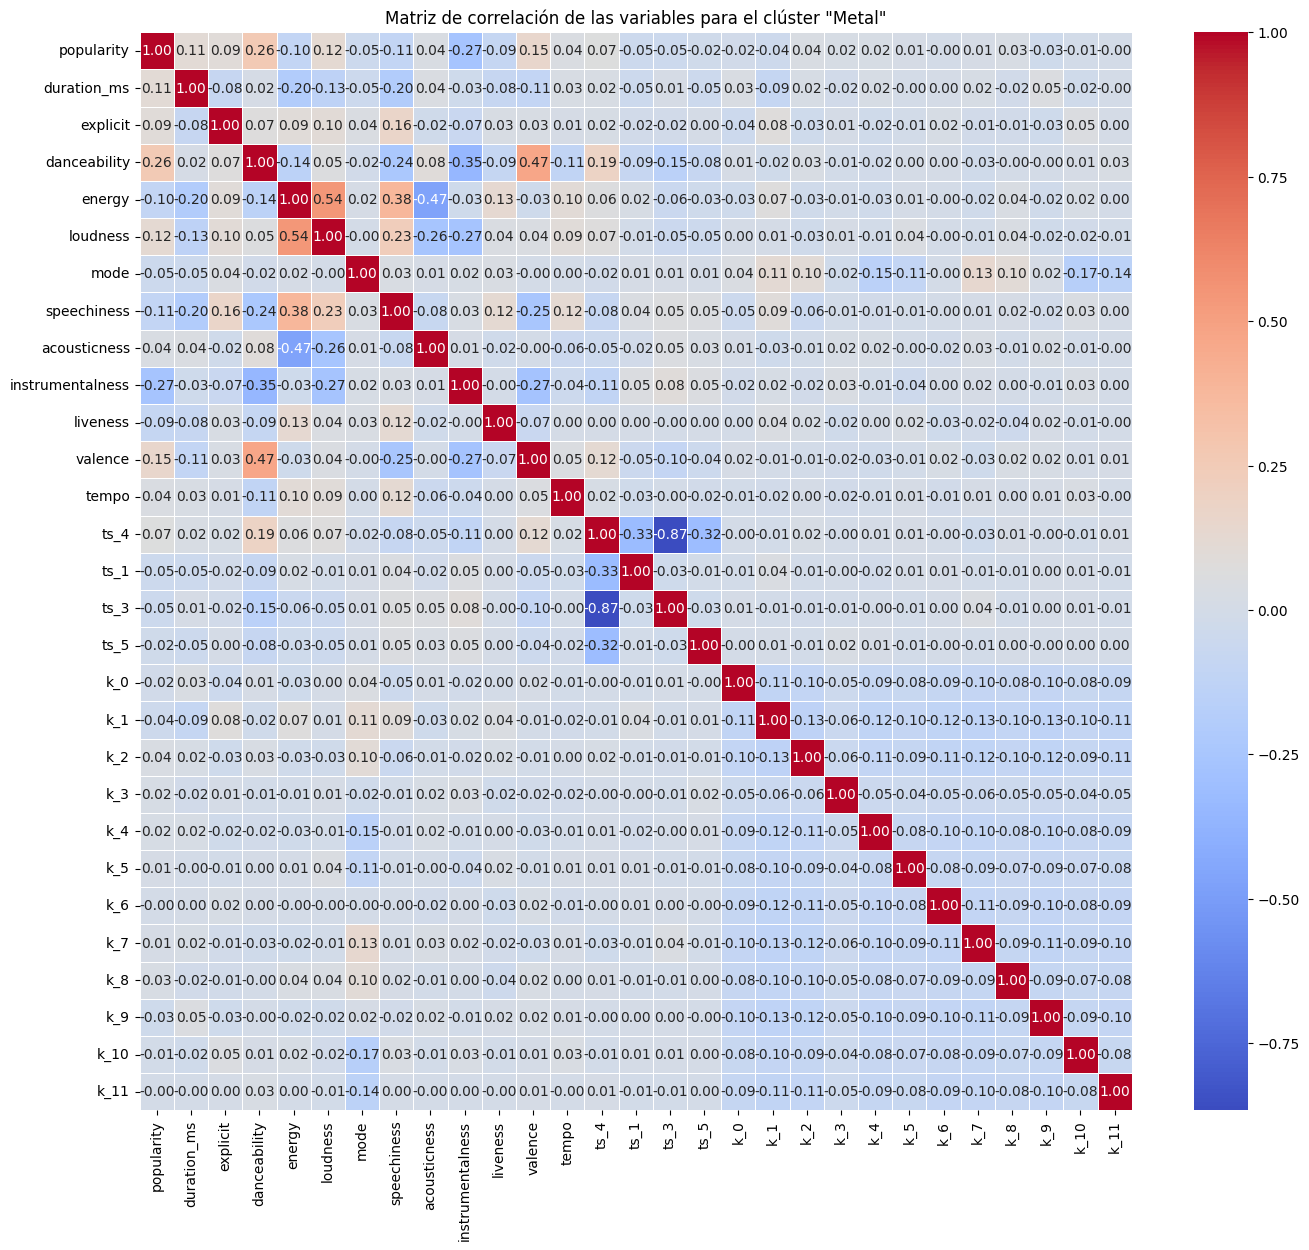

In [27]:
metal_data = df[df['is_metal'] == 1]
metal_numeric = metal_data.drop(columns=non_feature_columns + ['ts_0'])
correlation_matrix = metal_numeric.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación de las variables para el clúster "Metal"')
plt.show()

En este clúster se recogen los géneros de la conocida como música _metal_ y que está caracterizada por su alta _energía_...

In [28]:
X = df.drop(columns=non_feature_columns)  # Features
y = df['is_metal']  # Target

/tmp/ipykernel_7759/2810685619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


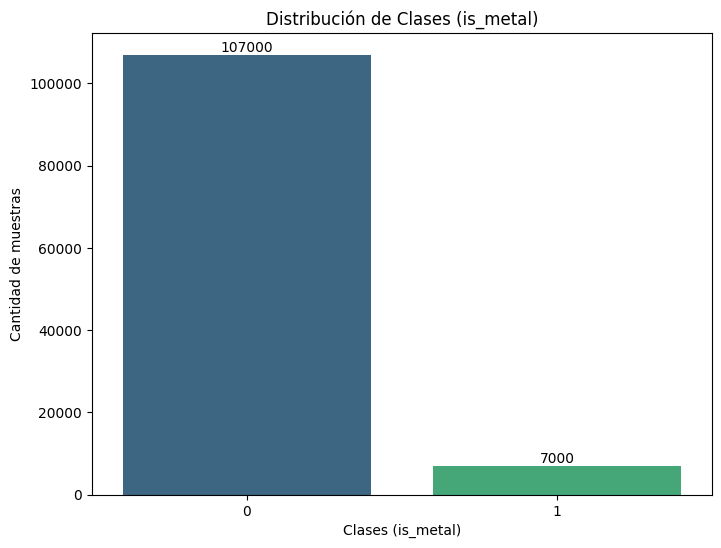

In [29]:
def plot_class_counts(y):
    class_counts = y.value_counts()

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.text(0, class_counts[0], str(class_counts[0]), ha='center', va='bottom')
    plt.text(1, class_counts[1], str(class_counts[1]), ha='center', va='bottom')

    # Añadir etiquetas y título
    plt.xlabel('Clases (is_metal)')
    plt.ylabel('Cantidad de muestras')
    plt.title('Distribución de Clases (is_metal)')
    plt.show()
plot_class_counts(y)

Se puede observar que el problema tiene un gran problema de desbalanceo de clases

#### 4 - Visualizar los datos y sus distribuciones

PCA Varianza Acumulada:
 [0.20369191 0.30660747 0.4013315  0.47814145 0.54823338 0.61389769
 0.67604865 0.73237448 0.78821361 0.8361005  0.8768841  0.90634224
 0.92798319 0.9372923  0.94497239 0.9522003  0.95883252 0.9651521
 0.97087009 0.97625751 0.98155708 0.98633807 0.99080325 0.99506732
 0.9972572  0.99917686 0.99988283 1.         1.         1.        ]


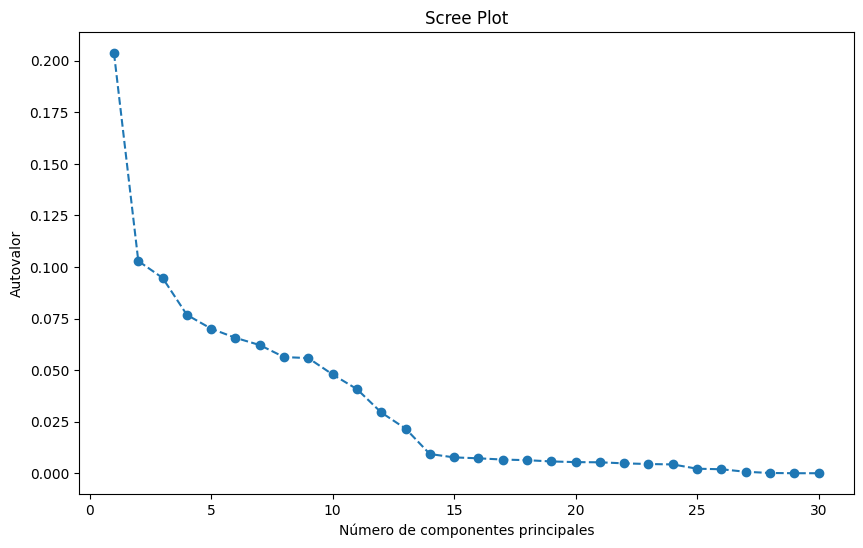

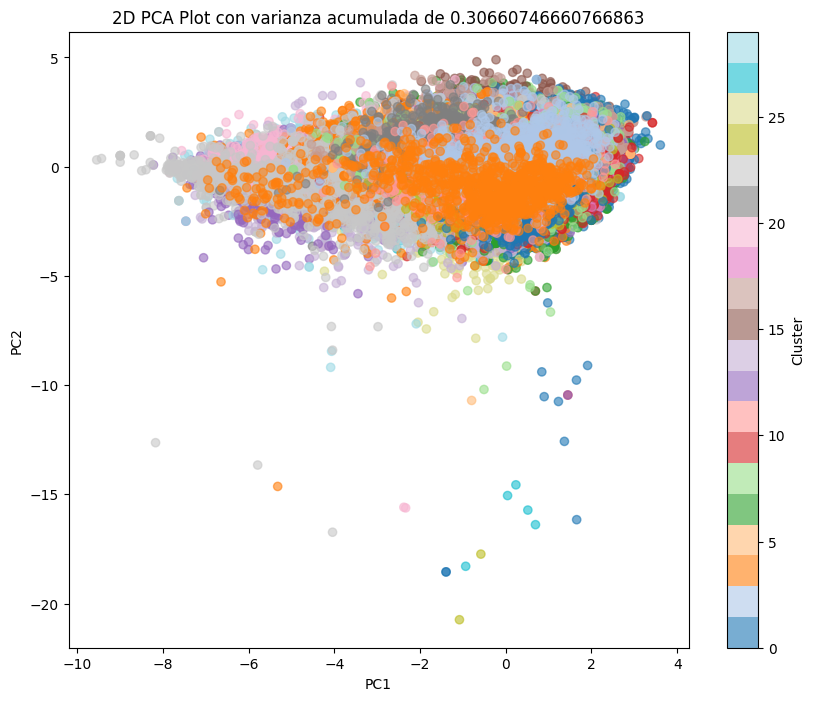

In [30]:
# Aplicar PCA
pca = PCA()
pca_result = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
print("PCA Varianza Acumulada:\n", cumulative_explained_variance)

# Dataframe con los datos del PCA para los plots
pca_df = pd.DataFrame(data=pca_result[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['cluster'] = df['cluster'].values

# Mostrar el scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de componentes principales')
plt.ylabel('Autovalor')
plt.title('Scree Plot')
plt.show()

# 2D Features con PCA
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='tab20', alpha=0.6)
plt.colorbar(label='Cluster')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"2D PCA Plot con varianza acumulada de {cumulative_explained_variance[1]}")
plt.show()

El grafico no es nada representativo. Varianza acumulada muy baja y tampoco mejora con las 3 primeras componentes principales. Este método de visualización no es adecuado en este caso y no nos aporta nueva información. Ya sabíamos que las clases parecen estar muy aglomeradas y los géneros musicales normalmente combinan elementos unos de otros.

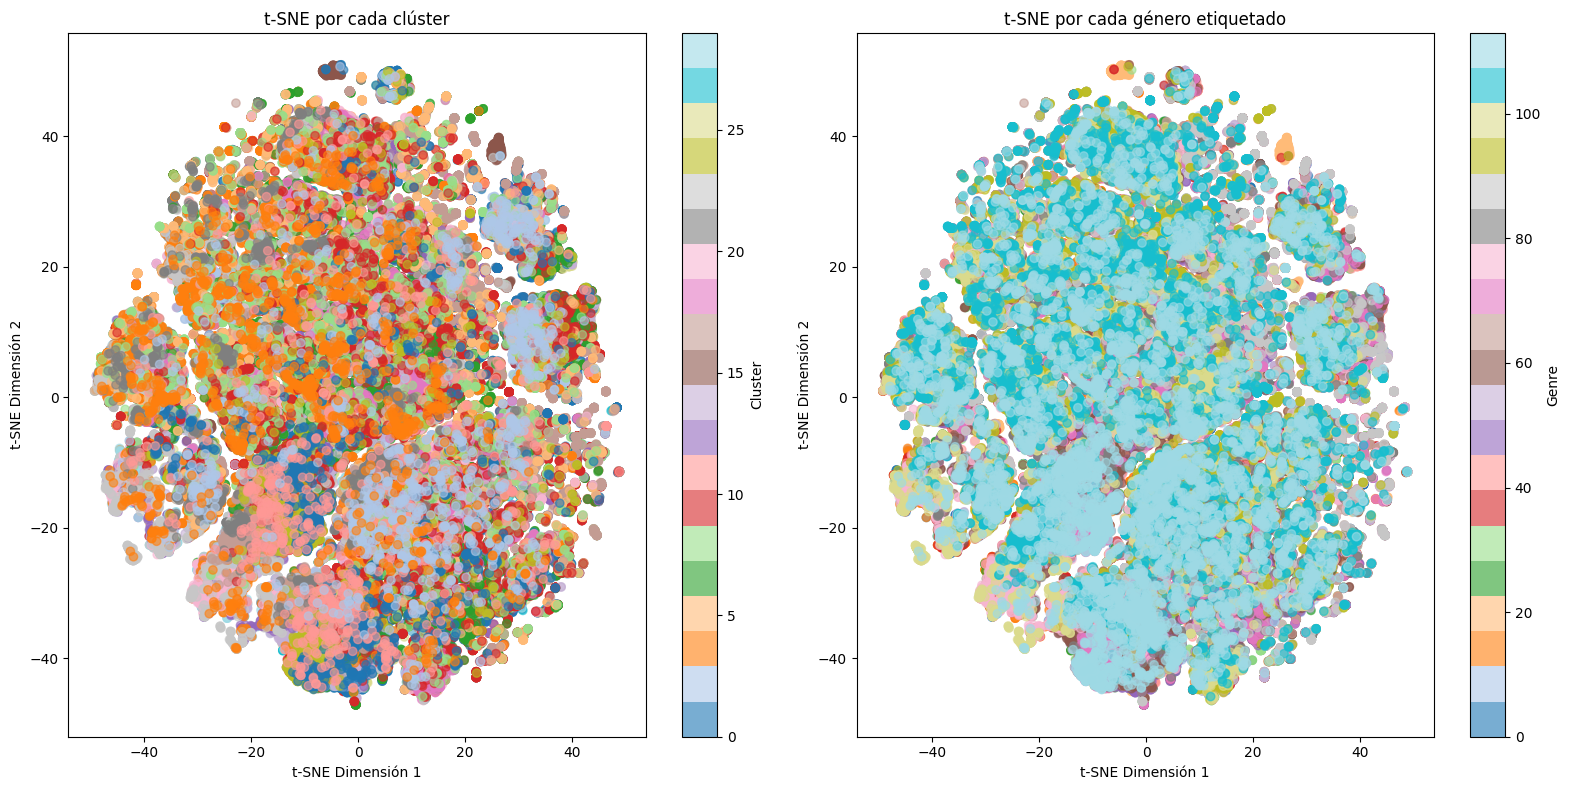

In [31]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate=200, max_iter=1000)
tsne_result = tsne.fit_transform(X)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['track_genre_encoded'] = df['track_genre_encoded'].values
tsne_df['cluster'] = df['cluster'].values

# t_SNE Clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
scatter1 = axes[0].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['cluster'], cmap='tab20', alpha=0.6)
axes[0].set_title("t-SNE por cada clúster")
axes[0].set_xlabel("t-SNE Dimensión 1")
axes[0].set_ylabel("t-SNE Dimensión 2")
fig.colorbar(scatter1, ax=axes[0], label='Cluster')

# t_SNE Genres
scatter2 = axes[1].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['track_genre_encoded'], cmap='tab20', alpha=0.6)
axes[1].set_title("t-SNE por cada género etiquetado")
axes[1].set_xlabel("t-SNE Dimensión 1")
axes[1].set_ylabel("t-SNE Dimensión 2")
fig.colorbar(scatter2, ax=axes[1], label='Genre')

plt.tight_layout()
plt.show()

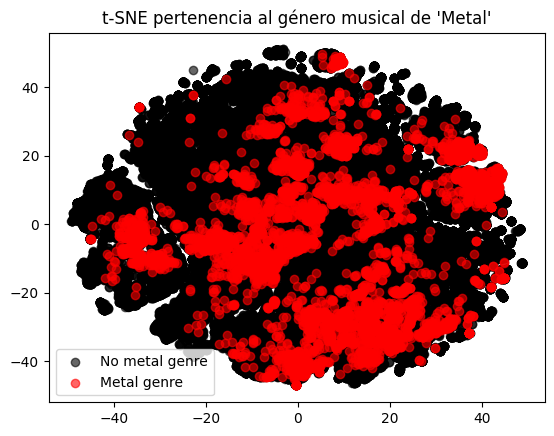

In [32]:
tsne_df['is_metal'] = np.where( df['is_metal'], True, False)
plt.scatter(tsne_df[~tsne_df['is_metal']]['TSNE1'], tsne_df[~tsne_df['is_metal']]['TSNE2'], alpha=0.6, label='No metal genre', c='black')
plt.scatter(tsne_df[tsne_df['is_metal']]['TSNE1'], tsne_df[tsne_df['is_metal']]['TSNE2'], alpha=0.6, label='Metal genre', c='red')
plt.title("t-SNE pertenencia al género musical de 'Metal'")
plt.legend()
plt.show()

#### 5 - Detección de outliers

Como se ha comentado, la asignación de un género musical a una canción no siempre es clara. Además, en este caso de estudio, estamos considerando el género musical "metal" para realizar el estudio, género que a su vez es una agrupación de otros subgéneros y ya se ha visto como las variables descriptivas de las canciones no siguen una distribución normal, son asimétricas y parecen presentar outliers.
Por esta razón es muy interesante determinar con qué tipo de outliers nos podemos encontrar y determinar si a la hora de entrenar un clasificador es mejor considerar o no considerar estas canciones.

Una primera opción que, aunque sencilla, se ve interesante es el de asumir que las features deben de seguir una distribución normal...

##### Z-Score

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_num_outliers_by_thresholds(z_scores, thresholds: list, title=""):
    num_outliers = []
    for thr in thresholds:
        outliers = (z_scores > thr).any(axis=1)
        num_outliers.append(outliers.sum())
    plt.plot(thresholds, num_outliers)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_z_outliers_by_threshols(z_scores, tsne_df, thresholds: list):
    num_plots = len(thresholds)
    cols = math.ceil(math.sqrt(num_plots))
    rows = math.ceil(num_plots / cols)

    plt.tight_layout()
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), sharex=True, sharey=True)
    axes = np.array(axes).reshape(rows, cols)
    for thr, i in zip(thresholds, range(num_plots)):
        r, c = divmod(i, cols)
        outliers = (z_scores > thr).any(axis=1)
        tsne_df['is_outlier_zscore'] = outliers

        # Show graph
        axes[r,c].scatter(tsne_df[~tsne_df['is_outlier_zscore']]['TSNE1'], tsne_df[~tsne_df['is_outlier_zscore']]['TSNE2'], alpha=0.6, label='Normal', c='black')
        axes[r,c].scatter(tsne_df[tsne_df['is_outlier_zscore']]['TSNE1'], tsne_df[tsne_df['is_outlier_zscore']]['TSNE2'], alpha=0.6, label='Outlier', c='red')
        axes[r,c].set_title(f"Outliers según Z-Score > {thr} en t-SNE")
        axes[r,c].set_xlabel("PC1")
        axes[r,c].set_ylabel("PC2")
    
    plt.legend()
    plt.show()

/tmp/ipykernel_26469/1200974403.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


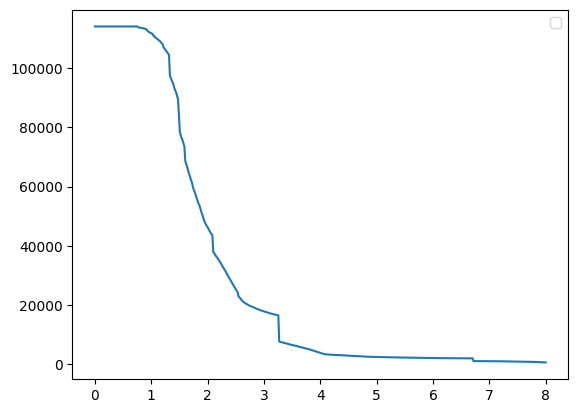

In [25]:
# Calcular Z-Score para todas las features
z_scores = np.abs(zscore(X))

# Mostrar el número de outliers variando el threshold
plot_num_outliers_by_thresholds(z_scores, np.linspace(0, 8, num=500))

# plot_z_outliers_by_threshols(z_scores, tsne_df, [2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6])

Vamos a considerar un threshold de $3.5$ para el outlierness de z_score. ¿Cuál es la canción con mayor z_score? ¿Y cuál es la que tiene menor valor?

In [26]:
threshold = 3.5  # Umbral para considerar un outlier
outliers = (z_scores > threshold).any(axis=1)

df['is_outlier_zscore'] = outliers
#df['z_scores'] = z_scores
non_feature_columns.append("z_scores")  
non_feature_columns.append("is_outlier_zvalue")
print(f"Total de outliers detectados: {df['is_outlier_zscore'].sum()}")

Total de outliers detectados: 6540


In [27]:
outlier_magnitudes = z_scores.sum(axis=1)  

max_outlier_idx = np.argmax(outlier_magnitudes)  # Índice con el mayor Z-Score acumulado
min_outlier_idx = np.argmin(outlier_magnitudes)  # Índice con el menor Z-Score acumulado

max_outlier_instance = df.iloc[max_outlier_idx]
min_outlier_instance = df.iloc[min_outlier_idx]

# Mostrar resultados
print("Instancia con el mayor Z-Score acumulado (outlier más extremo):")
print(max_outlier_instance)
print("\nInstancia con el menor Z-Score acumulado (outlier menos extremo):")
print(min_outlier_instance)

Instancia con el mayor Z-Score acumulado (outlier más extremo):
popularity                                     0.123805
duration_ms                                   31.426575
explicit                                      -0.305767
danceability                                   -3.26608
energy                                        -2.547911
key                                            1.598569
loudness                                      -5.342684
mode                                           0.753988
speechiness                                    -0.80063
acousticness                                   1.900901
instrumentalness                               0.736385
liveness                                      -0.533431
valence                                       -1.828544
tempo                                         -4.074574
time_signature                                -9.024189
Unnamed: 0                                       101517
track_id                         5m00VnX

La pista de audio que presenta el mayor Z-score acumulado de todo el dataset es _Electric Fan (Sound Masking Fan)_ de Electric Dreams con el género asignado de _sleep_. Es interesante que una pista de audio del sonido de un ventilador eléctrico sea el outlier más significativo atendiendo únicamente al Z-Score, pero en cierta manera se podría interpretar que al ser un sonido muy monótono y cercano al ruido blanco se diferencia bastante del resto de canciones.

En contraposición, la canción de salsa _Celo_ de Willie Colón es aquella que presenta menos índice Z-score acumulado en todo el dataset y, de forma subjetiva, sí que parece ajustarse al género musical asignado.

##### Local Outlier Factor (LOF)

Detección de outliers basado en vecindad. Concretamente se va a calcular el Local Outlier Factor o LOF

In [46]:
### LocalOutlierFactor #####################################################################
clf = LocalOutlierFactor(n_neighbors=20)
outliers_pred = clf.fit_predict(X)
outlier_map = {
    1: False,   # No es un outlier
    -1: True    # Sí es un outlier    
}
# clf.negative_outlier_factor_

df['is_outlier_lofscore'] = np.vectorize(outlier_map.get)(outliers_pred)
non_feature_columns.append('is_outlier_lofscore')
print(f"Total de outliers detectados: {df['is_outlier_lofscore'].sum()}")
print(f"El Local Factor Outlierness threshold calculado es: {clf.offset_}")

Total de outliers detectados: 2161
El Local Factor Outlierness threshold calculado es: -1.5


/workspaces/KISA/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [47]:
df.head()

popularity  duration_ms  explicit  danceability    energy       key  \
0    1.782627     0.024575 -0.305767      0.629244 -0.717148 -1.210442   
1    0.975633    -0.730859 -0.305767     -0.845908 -1.889980 -1.210442   
2    1.065299    -0.160332 -0.305767     -0.742186 -1.122669 -1.491343   
3    1.692961    -0.243214 -0.305767     -1.733304 -2.312994 -1.491343   
4    2.186125    -0.271919 -0.305767      0.295030 -0.788711 -0.929541   

   loudness      mode  speechiness  acousticness  instrumentalness  liveness  \
0  0.300828 -1.326281     0.551848     -0.850202         -0.504109  0.758743   
1 -1.784744  0.753988    -0.078993      1.831732         -0.504094 -0.591211   
2 -0.293288  0.753988    -0.273826     -0.315499         -0.504112 -0.507167   
3 -2.039252  0.753988    -0.457309      1.774593         -0.503883 -0.428376   
4 -0.282750  0.753988    -0.303145      0.463399         -0.504112 -0.686285   

    valence     tempo  time_signature  Unnamed: 0                track_id  \
0  0.929306 -1.141863        0.221823           0  5SuOikwiRyPMVoIQDJUgSV   
1 -0.798690 -1.489717        0.221823           1  4qPNDBW1i3p13qLCt0Ki3A   
2 -1.365688 -1.528312        0.221823           2  1iJBSr7s7jYXzM8EGcbK5b   
3 -1.276974  1.987859       -2.089680           3  6lfxq3CG4xtTiEg7opyCyx   
4 -1.184403 -0.073348        0.221823           4  5vjLSffimiIP26QG5WcN2K   

                  artists                                         album_name  \
0             Gen Hoshino                                             Comedy   
1            Ben Woodward                                   Ghost (Acoustic)   
2  Ingrid Michaelson;ZAYN                                     To Begin Again   
3            Kina Grannis  Crazy Rich Asians (Original Motion Picture Sou...   
4        Chord Overstreet                                            Hold On   

                   track_name track_genre  track_genre_encoded  cluster  \
0                      Comedy    acoustic                    0       11   
1            Ghost - Acoustic    acoustic                    0       11   
2              To Begin Again    acoustic                    0       11   
3  Can't Help Falling In Love    acoustic                    0       11   
4                     Hold On    acoustic                    0       11   

   is_metal  is_outlier_zscore  is_outlier_lofscore  
0         0              False                False  
1         0              False                False  
2         0              False                False  
3         0              False                False  
4         0              False                False

##### ¿Cómo tratar los outliers?

Instancias donde ambos métodos coinciden como outliers: 111
Instancias que solo son outliers con Z-Score: 6429
Instancias que solo son outliers con LOF: 2050


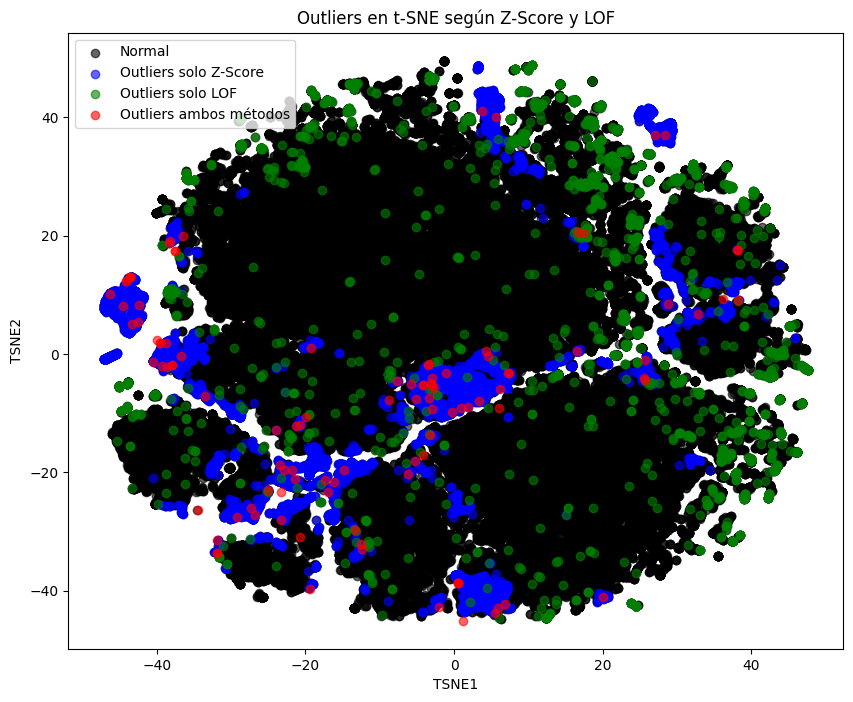

In [69]:
outliers_both = df[df['is_outlier_zscore'] & df['is_outlier_lofscore']]
outliers_only_z = df[(df['is_outlier_zscore'] & ~df['is_outlier_lofscore'])]
outliers_only_lof = df[(~df['is_outlier_zscore'] & df['is_outlier_lofscore'])]

# Mostrar los resultados
print(f"Instancias donde ambos métodos coinciden como outliers: {len(outliers_both)}")
print(f"Instancias que solo son outliers con Z-Score: {len(outliers_only_z)}")
print(f"Instancias que solo son outliers con LOF: {len(outliers_only_lof)}")

# Plotear los resultados en t-SNE
tsne_df['is_outlier_both']      = np.where( df['is_outlier_zscore'] & df['is_outlier_lofscore'], True, False)
tsne_df['is_outlier_only_z']    = np.where( df['is_outlier_zscore'] & ~df['is_outlier_lofscore'], True, False)
tsne_df['is_outlier_only_lof']  = np.where( ~df['is_outlier_zscore'] & df['is_outlier_lofscore'], True, False)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_df[~tsne_df['is_outlier_both']]['TSNE1'],      tsne_df[~tsne_df['is_outlier_both']]['TSNE2'],      alpha=0.6, label='Normal', c='black')               # Sin outliers en ambos
plt.scatter(tsne_df[tsne_df['is_outlier_only_z']]['TSNE1'],     tsne_df[tsne_df['is_outlier_only_z']]['TSNE2'],     alpha=0.6, label='Outliers solo Z-Score', c='blue') # Outliers detectados solo por Z-Score
plt.scatter(tsne_df[tsne_df['is_outlier_only_lof']]['TSNE1'],   tsne_df[tsne_df['is_outlier_only_lof']]['TSNE2'],   alpha=0.6, label='Outliers solo LOF', c='green')    # Outliers detectados solo por LOF
plt.scatter(tsne_df[tsne_df['is_outlier_both']]['TSNE1'],       tsne_df[tsne_df['is_outlier_both']]['TSNE2'],       alpha=0.6, label='Outliers ambos métodos', c='red') # Outliers detectados por ambos métodos (Z-Score y LOF)

plt.title("Outliers en t-SNE según Z-Score y LOF")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend()
plt.show()


De todo este anállisis, podemos extraer algunas conclusiones. En primer lugar, es complicado distinguir los géneros musicales en base a las variables tabulares al menos de forma visual. Los métodos tradicionales no consiguen representar adecuadamente los datos en 2 dimensiones y no se consiguen distinguir cláramente los distintos géneros musicales. Sin embargo, sí que es posible realizar un agrupamiento por similitud de los géneros musicales utilizando una clusterización aglomerativa. De esta manera se ha conseguido agrupar los géneros para crear la clase de estudio: el género musical de metal que agrupa varios sub-géneros. En cuanto a los outliers, se ha decidido mantenerlos en el dataset ya que pueden proporcionar información valiosa sobre los límites de los géneros musicales, ya que de por sí son límites difusos. 

## Entrenamiento

Antes de comenzar, se va a realizar un split para generar un conjunto de test en el cual se podrán comparar los distintos modelos. Se va a emplear XGBoost entrenado directamente sobre todos los datos de entrenamiento como baseline. 

In [33]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [40]:
def show_evaluation_report(model):
    y_pred = model.predict(X_test)
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print(f"\nF1-Score en el conjunto de prueba:")
    print(f1_score(y_test, y_pred))


def show_preccision_recall(model):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Graficar la curva de precisión-recall
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], label='Precisión')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Umbral de Decisión')
    plt.ylabel('Puntuación')
    plt.title('Curva de Precisión-Recall')
    plt.legend()
    plt.show()

def show_ROC_curve(model):
    # Calcular la curva ROC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

### XGBoostClassifier

Muchos algoritmos de clasificación, como XGBoost, permiten asignar pesos a las clases para dar más importancia a la clase minoritaria durante el entrenamiento.

In [39]:
# Ratio de desbalanceo
(y_train == 0).sum() / (y_train == 1).sum()

np.float64(15.285714285714286)

In [58]:
def train_xgboost_baseline_model(model_name):
    model_path = os.path.join(os.getcwd(), f"{model_name}.pkl")
    if os.path.exists(model_path):
        return joblib.load(model_path)

    print("Haciendo GridSearch")
    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'scale_pos_weight': [10, 15, 20]
    }
    # grid_search.best_params_: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 10, 'subsample': 0.8}
    # Modelo base de XGBoost
    model = XGBClassifier(random_state=42, eval_metric='logloss')
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model found
    xgboost_baseline_model = grid_search.best_estimator_
    joblib.dump(xgboost_baseline_model, model_path)
    print("Mejores parámetros encontrados: ")
    print(grid_search.best_params_)
    
    return xgboost_baseline_model
xgboost_baseline_model = train_xgboost_baseline_model("xgboost_baseline_model")
show_evaluation_report(xgboost_baseline_model)

Haciendo GridSearch
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=15, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=15, subsample=0.

In [65]:
# Anterior

Matriz de Confusión:
[[29846  2554]
 [  199  1601]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     32400
           1       0.39      0.89      0.54      1800

    accuracy                           0.92     34200
   macro avg       0.69      0.91      0.75     34200
weighted avg       0.96      0.92      0.93     34200



De los 1800 del test que son de la clase metal, ha fallado 200. El modelo consigue mucha precisión en la clase mayoritaria, pero tiene un rendimiento bajo con la clase minoritaria.

#### SMOTE (Oversampling)

Genera datos sintéticos

/tmp/ipykernel_62299/2810685619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


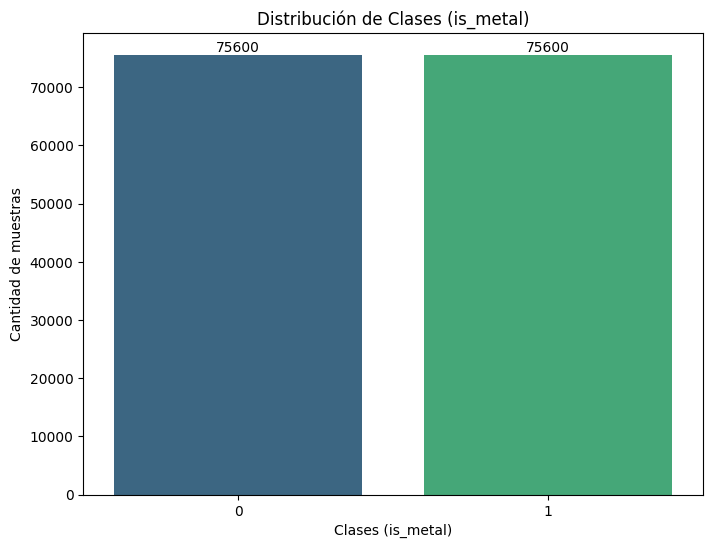

In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
plot_class_counts(y_train_resampled)

In [53]:
smote_xgboost_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Ajustar el peso de la clase positiva
    max_depth=5,                       # Profundidad máxima del árbol
    learning_rate=0.1,                 # Tasa de aprendizaje
    n_estimators=100,                  # Número de árboles
    random_state=42,
    eval_metric='logloss'              # Métrica de evaluación para clasificación binaria
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
smote_xgboost_model.fit(X_train_resampled, y_train_resampled)
show_evaluation_report(smote_xgboost_model)

Matriz de Confusión:
[[26767  5633]
 [   83  1717]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     32400
           1       0.23      0.95      0.38      1800

    accuracy                           0.83     34200
   macro avg       0.62      0.89      0.64     34200
weighted avg       0.96      0.83      0.88     34200



#### Undersampling

/tmp/ipykernel_62299/2810685619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


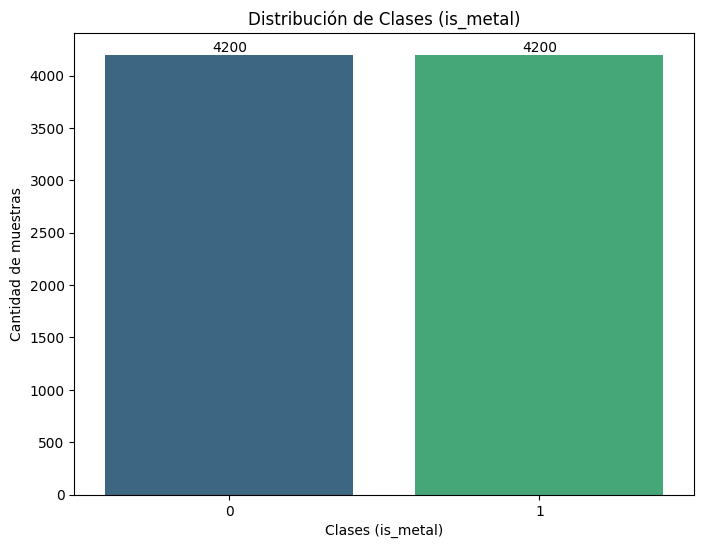

In [57]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)
plot_class_counts(y_train_resampled)

In [58]:
under_xgboost_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Ajustar el peso de la clase positiva
    max_depth=5,                       # Profundidad máxima del árbol
    learning_rate=0.1,                 # Tasa de aprendizaje
    n_estimators=100,                  # Número de árboles
    random_state=42,
    eval_metric='logloss'              # Métrica de evaluación para clasificación binaria
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
under_xgboost_model.fit(X_train_resampled, y_train_resampled)
show_evaluation_report(under_xgboost_model)

Matriz de Confusión:
[[24768  7632]
 [   37  1763]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.76      0.87     32400
           1       0.19      0.98      0.31      1800

    accuracy                           0.78     34200
   macro avg       0.59      0.87      0.59     34200
weighted avg       0.96      0.78      0.84     34200



#### Validación cruzada estratificada

In [57]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

# n_splits=5: Divide los datos en 5 folds.
# shuffle=True: Mezcla los datos antes de dividirlos.
# random_state=42: Fija la semilla para reproducibilidad.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scale_pos_weight = (y == 0).sum() / (y == 1).sum()
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Ajustar el peso de la clase positiva
    max_depth=5,                       # Profundidad máxima del árbol
    learning_rate=0.1,                 # Tasa de aprendizaje
    n_estimators=100,                  # Número de árboles
    random_state=42,
    eval_metric='logloss'              # Métrica de evaluación para clasificación binaria
)

y_pred = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
umbral_optimo = 0.3
y_pred = (y_pred >= umbral_optimo).astype(int)
# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_train, y_pred))

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_train, y_pred))


# Calcular el F1-Score en cada fold
f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print("F1-Score en cada fold:", f1_scores)
print("F1-Score promedio:", f1_scores.mean())


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     74900
           1       0.28      0.94      0.43      4900

    accuracy                           0.85     79800
   macro avg       0.64      0.89      0.67     79800
weighted avg       0.95      0.85      0.88     79800


Matriz de Confusión:
[[62951 11949]
 [  307  4593]]
F1-Score en cada fold: [0.52385914 0.52491694 0.52938724 0.51982379 0.52350115]
F1-Score promedio: 0.5242976526036941


#### Búsqueda de hyperparámetros con GridSearch y validación cruzada estratificada

### RandomForest

In [55]:
def train_forest_baseline_model(model_name):
    model_path = os.path.join(os.getcwd(), f"{model_name}.pkl")
    if os.path.exists(model_path):
        print("Cargando modelo entrenado...")
        return joblib.load(model_path)

    print("Haciendo GridSearch...")
    # Definir el espacio de búsqueda de hiperparámetros
    # Ajustar pesos de clase
    class_weights = {0: 1, 1: 10}  

    # grid_search.best_params_: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }

    model = RandomForestClassifier(class_weight=class_weights)
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=5, 
        scoring='f1')

    # Entrenar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model found
    xgboost_baseline_model = grid_search.best_estimator_
    joblib.dump(xgboost_baseline_model, model_path)
    print("Mejores parámetros encontrados: ")
    print(grid_search.best_params_)
    
    return xgboost_baseline_model
forest_baseline_model = train_forest_baseline_model("forest_baseline_model")
show_evaluation_report(forest_baseline_model)

Haciendo GridSearch...
Mejores parámetros encontrados: 
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}
Matriz de Confusión:
[[31307   793]
 [  758  1342]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     32100
           1       0.63      0.64      0.63      2100

    accuracy                           0.95     34200
   macro avg       0.80      0.81      0.80     34200
weighted avg       0.96      0.95      0.95     34200


F1-Score en el conjunto de prueba:
0.6337662337662338


## Comparación de modelos

Dado que ambos modelos se evalúan en el mismo conjunto de prueba (X_test, y_test), los resultados son datos pareados. Esto significa que las predicciones de ambos modelos están relacionadas, ya que se basan en las mismas muestras de prueba. Esta prueba compara las medias de dos grupos relacionados (en este caso, las predicciones de los dos modelos).

Para comparar estadísticamente los dos modelos, suele ser una opción común utilizar la prueba t de Student para muestras pareadas o la prueba de Wilcoxon (no paramétrica). En este caso y debido a que los datos no siguen una distribución normal (comprobado en la sección de exploración de datos), se ha optado por la prueba de Wilcoxon.

In [ ]:

# Predecir con XGBoostClassifier
y_pred_xgb = xgb_model.predict(X_test)

# Predecir con RandomForest
y_pred_rf = rf_model.predict(X_test)

# Realizar la prueba de Wilcoxon
w_stat, p_value = wilcoxon(y_pred_xgb, y_pred_rf)

print(f"Estadístico de Wilcoxon: {w_stat}")
print(f"Valor p: {p_value}")

# Interpretación
if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa entre los modelos.")
else:
    print("No hay una diferencia estadísticamente significativa entre los modelos.")